##### Мышковец С.А., v.1 24.01.2023

Решение задачи:

Для произвольно выбранного датасета провести обработку данных и построить предсказательную модель с использованием функционала pySpark (если есть проблемы с выбором - использовать winequality-red.csv).

Вывод:

RandomForestClassifier показал достаточно высокую точность предсказания (0.55). LogisticRegression справилась с задаче намного хуже (0.48).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

# Загрузка данных.

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

23/01/30 19:18:49 WARN Utils: Your hostname, MacBook-Pro-Sviatlana.local resolves to a loopback address: 127.0.0.1; using 192.168.1.105 instead (on interface en0)
23/01/30 19:18:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/30 19:18:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.options(delimiter=";", header=True, inferSchema=True, 
#                         truncate=False
                       ).csv("winequality-red.csv")

In [4]:
df.count()

1599

In [5]:
df.show(3)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
+-------------+----------------+-----------+--------------+---------+-------------------+-----------

In [6]:
df.columns

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [7]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [8]:
df.summary().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|           quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|              1599|
|   mean

In [9]:
df.describe().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|           quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|              1599|
|   mean

# Удалим дубликаты, проверяем на нулевые значения.

In [10]:
#Removal of duplicate values
df_nodup = df.dropDuplicates()

In [11]:
df_nodup.count()

1359

In [12]:
#check the null column count using sql
from pyspark.sql.functions import col,isnan, when, count
df_nodup.select([count(when(isnan(a) | col(a).isNull(), a)).alias(a) for a in df_nodup.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+



In [13]:
df_nodup.groupBy("quality").count().show()  

+-------+-----+
|quality|count|
+-------+-----+
|      6|  535|
|      3|   10|
|      5|  577|
|      4|   53|
|      8|   17|
|      7|  167|
+-------+-----+



array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

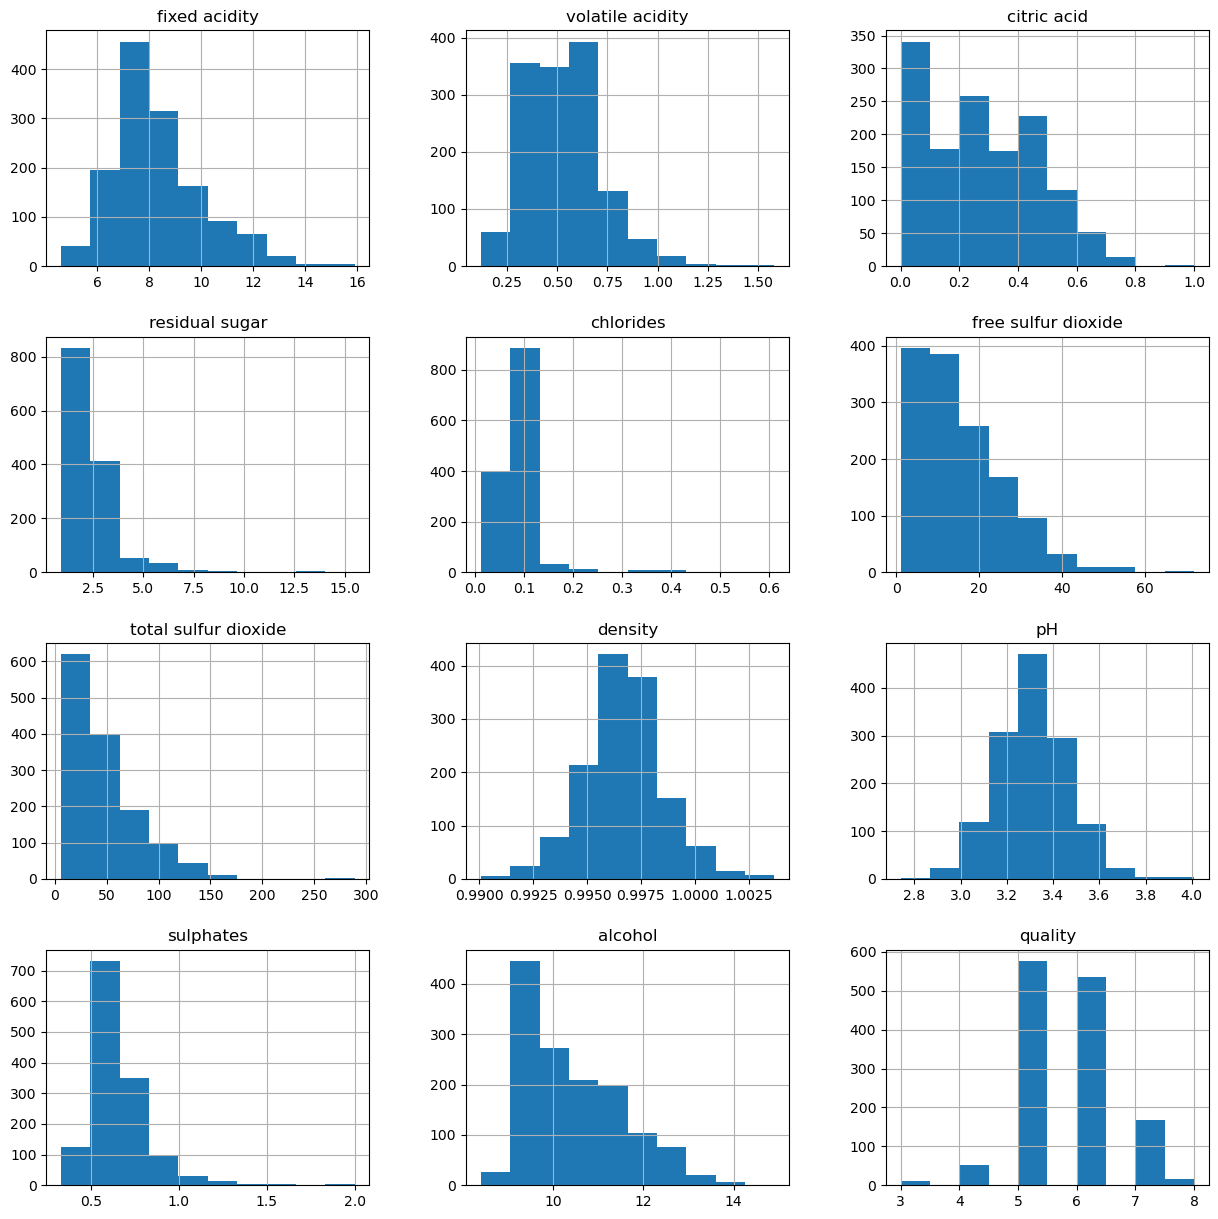

In [14]:
df_nodup.toPandas().hist(figsize=(15, 15))

# Модели

# RandomForestClassifier

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

In [16]:
df_nodup.columns

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

**Комбинируем все признаки и отделяем 'label' при помощи VectorAssembler.**

**Переименовываем 'quality' в'label'. Это необходимо для использования позже MulticlassClassificationEvaluator.**

In [25]:
df1 = df_nodup.withColumnRenamed("quality","label")

In [35]:
from pyspark.ml.feature import VectorAssembler
features = df1.drop(df1.label).columns

va = VectorAssembler(inputCols = features, outputCol='features')

va_df = va.transform(df1)
va_df = va_df.select(['features', 'label'])
va_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[9.9,0.5,0.24,2.3...|    4|
|[7.9,0.72,0.01,1....|    5|
|[8.3,0.3,0.49,3.8...|    7|
+--------------------+-----+
only showing top 3 rows



**Разбиваем на train и test.**

In [36]:
(train, test) = va_df.randomSplit([0.7, 0.3])

In [37]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(featuresCol="features", labelCol="label")
rfc = rfc.fit(train)

pred = rfc.transform(test)
pred.show(3) 
 


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[4.6,0.52,0.15,2....|    4|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       6.0|
|[5.0,0.4,0.5,4.3,...|    6|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       6.0|
|[5.0,1.02,0.04,1....|    4|[0.0,0.0,0.0,0.96...|[0.0,0.0,0.0,0.04...|       5.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



**Оцениваем результат.**

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

In [39]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.5525273611899751
Confusion Matrix:
[[  0   0   2   1   0   0]
 [  0   0  11   4   1   0]
 [  0   0 129  33   0   0]
 [  0   0  56 112   4   0]
 [  0   0   4  51   9   0]
 [  0   0   0   3   0   0]]


# LogisticRegression

In [40]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.show(3)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[4.6,0.52,0.15,2....|    4|[-3.5282615777954...|[3.80141035231193...|       6.0|
|[5.0,0.4,0.5,4.3,...|    6|[-3.5279795293892...|[3.31282037936839...|       6.0|
|[5.0,1.02,0.04,1....|    4|[-3.5275333256140...|[2.73651328201077...|       5.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



In [41]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(predictions)
 
print("Prediction Accuracy: ", acc)
 
y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.48599163905740206
Confusion Matrix:
[[  0   0   3   0   0   0]
 [  0   0  12   4   0   0]
 [  0   0 138  24   0   0]
 [  0   0  77  95   0   0]
 [  0   0   7  57   0   0]
 [  0   0   0   3   0   0]]
